# Burgers' equation
#### Runtime result in this experiment:

Full order model: 0.276 sec (100%)

Reduced Order model with 2 modes: **0.035 sec (12%)**

Reference: Seyed Mahdi Hashemi and Herbert Werner (2011) Observer-based LPV Control of a Nonlinear PDE, CDC-ECC

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from sklearn.decomposition import TruncatedSVD
from time import time

## 1. Linear system drived from a finite difference method

In [2]:
# time iteration
def burgers(timestep, dt, ds, nu, w):
    wevol = w.reshape(1,-1)
    tmp = wevol[0]
    lam = dt/(2*ds)
    r = nu*dt/(ds**2)
    
    for t in timestep[1:]:
        tmp[1:-1] = w[1:-1] - lam*w[1:-1]*(w[2:]-w[:-2]) + r*(w[2:]-2*w[1:-1]+w[:-2])
        tmp[0] = 0
        tmp[-1] = 0
        wevol = np.concatenate([wevol, tmp.reshape(1,-1)], axis=0)
        w = tmp 
    return wevol

In [3]:
ds = 0.02 # spatial grid size
nu = 0.01 # viscosity
L = 1
s = np.linspace(0, L, int(L/ds)+1)
w = np.sin(2*np.pi*s) #np.zeros(int(L/ds)+1) #

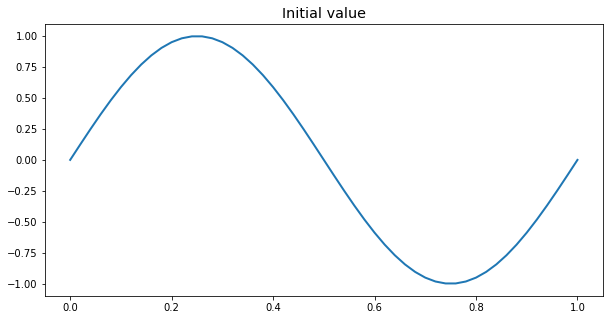

In [4]:
plt.figure(figsize=(10,5))
plt.plot(s, w, linewidth=2)
plt.title('Initial value', fontsize="x-large")
plt.show()

In [5]:
# time
t_end = 5
dt = 0.005
timestep = np.linspace(0, t_end, int(t_end/dt)+1)
print(len(timestep))

1001


In [6]:
wt = burgers(timestep, dt, ds, nu, w)
print(wt.shape)

(1001, 51)


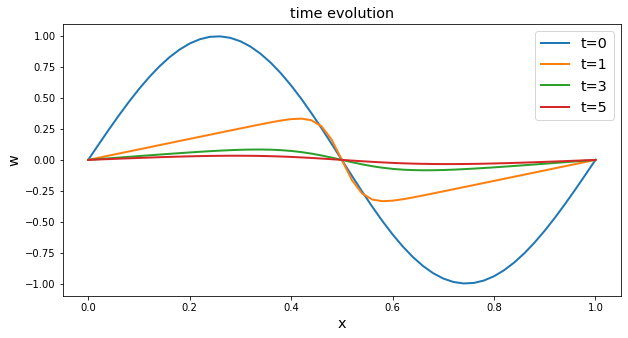

In [7]:
plt.figure(figsize=(10,5))
plt.plot(s, wt[0], linewidth=2)
plt.plot(s, wt[200], linewidth=2)
plt.plot(s, wt[600], linewidth=2)
plt.plot(s, wt[-1], linewidth=2)
plt.title('time evolution', fontsize="x-large")
plt.xlabel('x', fontsize="x-large")
plt.ylabel('w', fontsize="x-large")
plt.legend(['t=0','t=1','t=3','t=5'], fontsize="x-large")
plt.show()

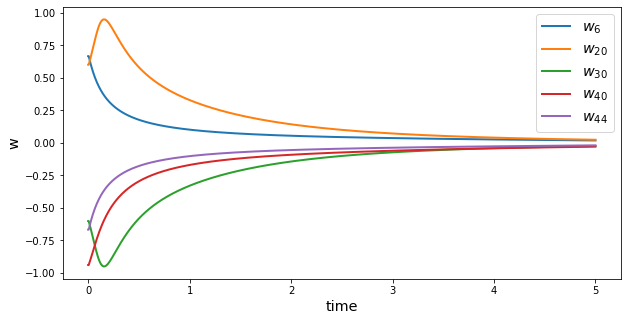

In [8]:
# plot
plt.figure(figsize=(10,5))
plt.plot(timestep, wt[:,6], linewidth=2)
plt.plot(timestep, wt[:,20], linewidth=2)
plt.plot(timestep, wt[:,30], linewidth=2)
plt.plot(timestep, wt[:,40], linewidth=2)
plt.plot(timestep, wt[:,44], linewidth=2)
plt.xlabel('time', fontsize="x-large")
plt.ylabel('w', fontsize="x-large")
plt.legend([r'$w_6$',r'$w_{20}$',r'$w_{30}$',r'$w_{40}$',r'$w_{44}$'], fontsize="x-large")
plt.show()

## 2. Matrix form

In [9]:
# A, B
def A(lam, r, w):
    num_states = len(w)
    A = np.zeros((num_states,num_states))
    A[0,0] = 1-2*r
    A[0,1] = -lam*w[0]+r
    for i in range(1,num_states-1):
        A[i,i] = 1-2*r
        A[i,i+1] = -lam*w[i]+r
        A[i,i-1] = lam*w[i]+r
    A[num_states-1,num_states-1] = 1-2*r
    A[num_states-1,num_states-2] = lam*w[-1]+r

    return A

def B(lam, r, w):
    num_states = len(w)
    B = np.zeros((num_states,2))
    B[0,0] = lam*w[0]+r
    B[-1,-1] = -lam*w[-1]+r
    return B

In [10]:
# linearization
# open loop
def open_loop_burgers(timestep, dt, ds, nu, w):

    w = w[1:-1].reshape(-1,1)
    
    wevol = w
    lam = dt/(2*ds)
    r = nu*dt/(ds**2)

    start = time()
    for t in range(1,len(timestep)):
        tmp = A(lam, r, w) @ w #+ B@u
        wevol = np.concatenate([wevol, tmp], axis=1)
        w = tmp
    print("Runtime:", time()-start)

    bd = np.zeros((len(wevol.T),1))
    wevol = np.concatenate([bd, wevol.T, bd], axis=1)
    return wevol

In [11]:
w = np.sin(2*np.pi*s)
wo = open_loop_burgers(timestep, dt, ds, nu, w)

Runtime: 0.2757132053375244


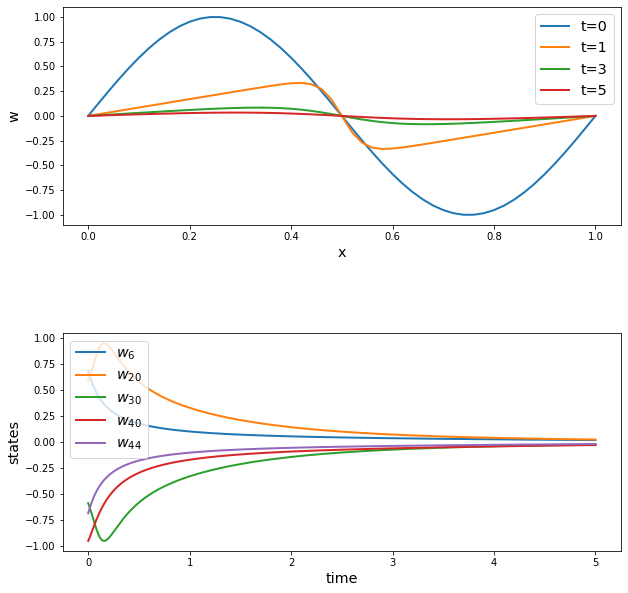

In [12]:
# plot
plt.figure(figsize=(10,10))
plt.subplots_adjust(wspace=0.1, hspace=0.5)
plt.subplot(2, 1, 1)
plt.plot(s, wo[0], linewidth=2)
plt.plot(s, wo[200], linewidth=2)
plt.plot(s, wo[600], linewidth=2)
plt.plot(s, wo[-1], linewidth=2)
plt.legend(['t=0','t=1','t=3','t=5'], fontsize="x-large")
plt.xlabel('x', fontsize="x-large")
plt.ylabel('w', fontsize="x-large")

plt.subplot(2, 1, 2)
plt.plot(timestep, wo[:,6], linewidth=2)
plt.plot(timestep, wo[:,20], linewidth=2)
plt.plot(timestep, wo[:,30], linewidth=2)
plt.plot(timestep, wo[:,40], linewidth=2)
plt.plot(timestep, wo[:,44], linewidth=2)
plt.xlabel('time', fontsize="x-large")
plt.ylabel('states', fontsize="x-large")
plt.legend([r'$w_6$',r'$w_{20}$',r'$w_{30}$',r'$w_{40}$',r'$w_{44}$'], fontsize="x-large")
plt.show()

## 3. Reduced Order Model

In [13]:
n_modes = 2
svd = TruncatedSVD(n_components=n_modes, random_state=42)
svd.fit(wo[:,1:-1])
V = svd.components_
print(V.shape)

print("Total energy: %.5f" %sum(svd.explained_variance_ratio_))
print("L2 error: %.5f" %np.mean((wo[:,1:-1]-(wo[:,1:-1] @ V.T)@V)**2))

(2, 49)
Total energy: 0.99586
L2 error: 0.00013


In [14]:
# Linear A0 + Aa = A 
def linA(lam, r, w):
    num_states = len(w)
    Aa = np.zeros((num_states,num_states))
    Aa[0,1] = -lam*w[0]
    for i in range(1,num_states-1):
        Aa[i,i+1] = -lam*w[i]
        Aa[i,i-1] = lam*w[i]
    Aa[num_states-1,num_states-2] = lam*w[-1]

    return Aa

In [15]:
# rom
def reduced_order_burgers(timestep, dt, ds, nu, w, V):

    w = w[1:-1].reshape(-1,1)
    
    wevol = w
    lam = dt/(2*ds)
    r = nu*dt/(ds**2)

    A0 = A(lam, r, np.zeros_like(w))@ V.T
    A1 = linA(lam, r, V[0].reshape(-1,1))@ V.T
    A2 = linA(lam, r, V[1].reshape(-1,1))@ V.T

    start = time()
    for t in range(1,len(timestep)):
        rho = V@w
        Ak = A0 + rho[0]*A1 + rho[1]*A2
        tmp = Ak@rho
        
        wevol = np.concatenate([wevol, tmp], axis=1)
        w = tmp
    print("Runtime:", time()-start)

    bd = np.zeros((len(wevol.T),1))
    wevol = np.concatenate([bd, wevol.T, bd], axis=1)
    return wevol

In [16]:
w = np.sin(2*np.pi*s)
wtt = reduced_order_burgers(timestep, dt, ds, nu, w, V)

Runtime: 0.03474116325378418


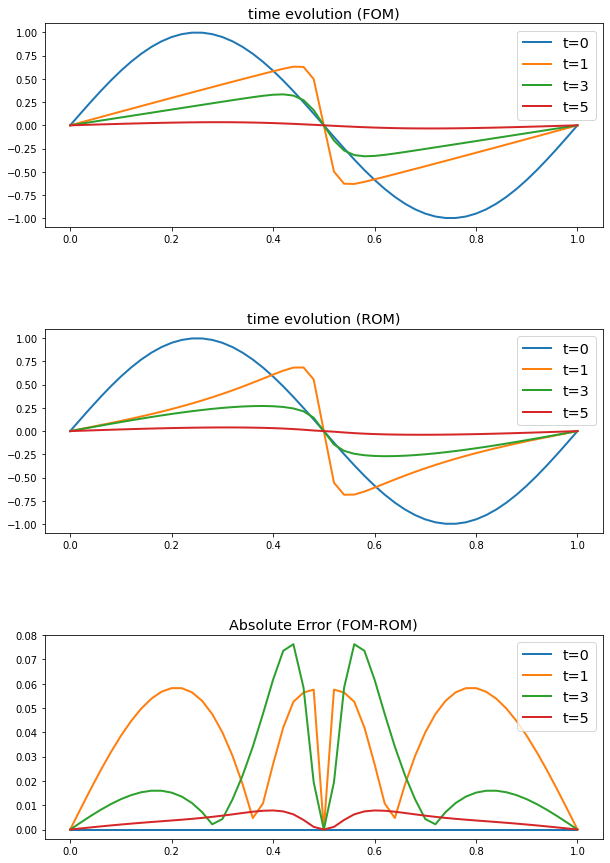

In [17]:
# plot
plt.figure(figsize=(10,15))
plt.subplots_adjust(wspace=0.1, hspace=0.5)
plt.subplot(3, 1, 1)
plt.plot(s, wo[0], linewidth=2)
plt.plot(s, wo[100], linewidth=2)
plt.plot(s, wo[200], linewidth=2)
plt.plot(s, wo[-1], linewidth=2)
plt.title('time evolution (FOM)', fontsize="x-large")
plt.legend(['t=0','t=1','t=3','t=5'], fontsize="x-large")

plt.subplot(3, 1, 2)
plt.plot(s, wtt[0], linewidth=2)
plt.plot(s, wtt[100], linewidth=2)
plt.plot(s, wtt[200], linewidth=2)
plt.plot(s, wtt[-1], linewidth=2)
plt.title('time evolution (ROM)', fontsize="x-large")
plt.legend(['t=0','t=1','t=3','t=5'], fontsize="x-large")

plt.subplot(3, 1, 3)
plt.plot(s, abs(wo[0]-wtt[0]), linewidth=2)
plt.plot(s, abs(wo[100]-wtt[100]), linewidth=2)
plt.plot(s, abs(wo[200]-wtt[200]), linewidth=2)
plt.plot(s, abs(wo[-1]-wtt[-1]), linewidth=2)
plt.title('Absolute Error (FOM-ROM)', fontsize="x-large")
plt.legend(['t=0','t=1','t=3','t=5'], fontsize="x-large")
plt.show()

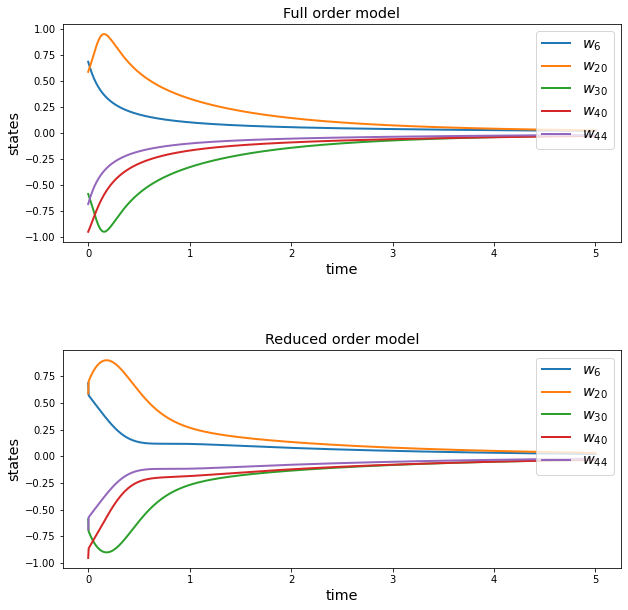

In [18]:
# plot
plt.figure(figsize=(10,10))
plt.subplots_adjust(wspace=0.1, hspace=0.5)
plt.subplot(2, 1, 1)
plt.plot(timestep, wo[:,6], linewidth=2)
plt.plot(timestep, wo[:,20], linewidth=2)
plt.plot(timestep, wo[:,30], linewidth=2)
plt.plot(timestep, wo[:,40], linewidth=2)
plt.plot(timestep, wo[:,44], linewidth=2)
plt.xlabel('time', fontsize="x-large")
plt.ylabel('states', fontsize="x-large")
plt.legend([r'$w_6$',r'$w_{20}$',r'$w_{30}$',r'$w_{40}$',r'$w_{44}$'], fontsize="x-large",loc='upper right')
plt.title('Full order model', fontsize="x-large")
plt.subplot(2, 1, 2)
plt.plot(timestep, wtt[:,6], linewidth=2)
plt.plot(timestep, wtt[:,20], linewidth=2)
plt.plot(timestep, wtt[:,30], linewidth=2)
plt.plot(timestep, wtt[:,40], linewidth=2)
plt.plot(timestep, wtt[:,44], linewidth=2)
plt.xlabel('time', fontsize="x-large")
plt.ylabel('states', fontsize="x-large")
plt.legend([r'$w_6$',r'$w_{20}$',r'$w_{30}$',r'$w_{40}$',r'$w_{44}$'], fontsize="x-large",loc='upper right')
plt.title('Reduced order model', fontsize="x-large")
plt.show()